In [26]:
pip install pingouin

  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196192 sha256=3250e48c47a5760563d4389a02c52b96fba51facd8eb7ecc9fcda63b5c0d9614
  Stored in directory: c:\users\владислав\appdata\local\pip\cache\wheels\75\b0\89\f6866fc5accea9bec04f4c9f2a242520d6e8e7b8fcf89e139c
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=c96397ef8cd14620bcdb8e6fa4676fa13ef89b0dbc2016de5e3e19aedc480f0f
  Stored in directory: c:\users\владислав\appdata\local\pip\cache\wheels\6a\33\c4\0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleutils
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
  Attempting uninstall: patsy
    Found existing installation: patsy 0.

In [43]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
import pingouin as pg
from tqdm.auto import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A' # Ссылка на яндекс диск

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Получаем dataframe
df = pd.read_csv(download_url, sep=';')

In [4]:
df['isBuy'] = (df.revenue > 0)*1

In [5]:
df.groupby('testgroup', as_index=0).agg({'revenue' : 'mean', 'isBuy' : 'mean'})

,testgroup,revenue,isBuy
0,a,25.413720,0.009540
1,b,26.751287,0.008906


In [7]:
df.user_id.nunique() == df.user_id.count()

True

In [11]:
df = df.set_index('user_id')

In [21]:
df_for_CR = df.pivot_table(index='testgroup', columns='isBuy', values='revenue', aggfunc='count')

In [22]:
df_for_CR

isBuy,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [32]:
expected, observed, stats = pg.chi2_independence(data=df, x='testgroup', y='isBuy')

In [33]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


<AxesSubplot:>

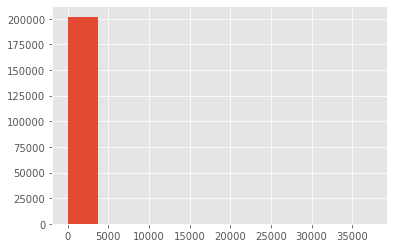

In [63]:
df.query('testgroup == "a"').revenue.hist()

<AxesSubplot:>

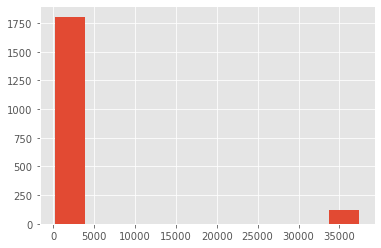

In [67]:
df.query('testgroup == "a" & revenue > 0').revenue.hist()

<AxesSubplot:>

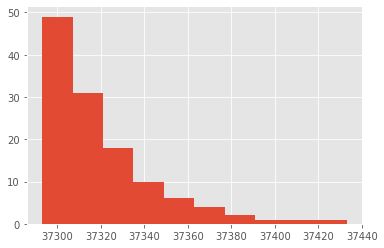

In [68]:
df.query('testgroup == "a" & revenue > 1000').revenue.hist()

<AxesSubplot:>

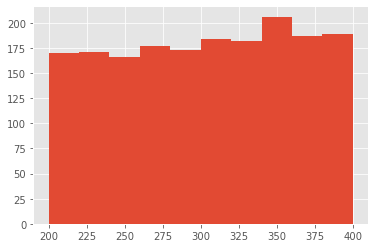

In [70]:
df.query('testgroup == "a" & 0 < revenue < 1000').revenue.hist()

<AxesSubplot:>

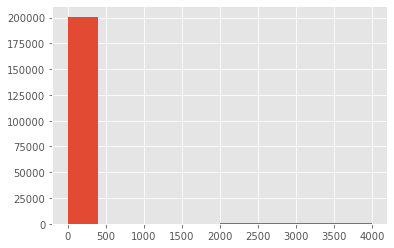

In [57]:
df.query('testgroup == "b"').revenue.hist()

<AxesSubplot:>

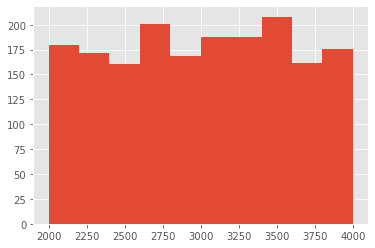

In [64]:
df.query('testgroup == "b" & revenue > 0').revenue.hist()

In [35]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрап-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

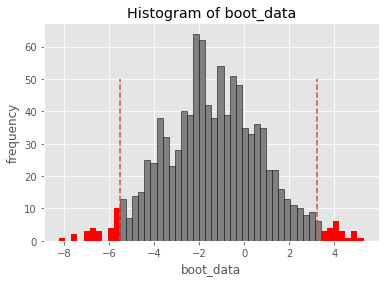

In [48]:
result = get_bootstrap(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)

In [49]:
result['p_value']

0.539113332724425

In [51]:
pg.mwu(df.query('testgroup == "a"').revenue.sample(1000), df.query('testgroup == "b"').revenue.sample(1000))

,U-val,alternative,p-val,RBC,CLES
MWU,499968.5,two-sided,0.988291,0.000063,0.499968


In [52]:
pg.ttest(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


# У группы A конверсия выше чем у группы В. Средний чек же стат значимо не отличается в группах.